In [1]:
import pydicom
from PIL import Image
import matplotlib.pyplot as plt
from pydicom import dcmread
from pydicom.data import get_testdata_file
import os
import numpy as np
import cv2



In [2]:
base_dir = "/home/shihab/Desktop/Machine Learning/Dataset/3dImageDataset/minData/147-Tahera Sultana. Dr_Nurul_Amin"


In [7]:
import os
import pydicom
import numpy as np

# Folder containing DICOM files
dicom_folder = "/home/shihab/Desktop/Machine Learning/Dataset/3dImageDataset/minData/147-Tahera Sultana. Dr_Nurul_Amin"

# Load all DICOM files
dicom_files = [pydicom.dcmread(os.path.join(dicom_folder, f)) for f in os.listdir(dicom_folder) if f.endswith('.dcm')]

# Convert DICOM pixel data to a 3D numpy array
image_stack = np.stack([f.pixel_array for f in dicom_files])

print(f"Image stack shape: {image_stack.shape}")  # (num_slices, height, width)


Image stack shape: (450, 600, 600)


In [13]:

from skimage import exposure
from scipy.ndimage import gaussian_filter

# Normalize and enhance contrast
normalized_stack = exposure.rescale_intensity(image_stack, out_range=(0, 255)).astype(np.uint8)

# Apply Gaussian smoothing
smoothed_stack = gaussian_filter(normalized_stack, sigma=1)

print(f"Preprocessed stack shape: {smoothed_stack.shape}")


Preprocessed stack shape: (450, 600, 600)


In [14]:
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects

# Apply Otsu's thresholding
segmented_stack = []
for slice in smoothed_stack:
    threshold = threshold_otsu(slice)
    binary_mask = slice > threshold
    segmented_stack.append(binary_mask)

segmented_stack = np.array(segmented_stack)

# Remove small objects
cleaned_stack = np.array([remove_small_objects(mask, min_size=100) for mask in segmented_stack])


In [16]:
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy.ndimage import label

# Perform watershed segmentation
labels = []
for slice in smoothed_stack:
    distance = -gaussian_filter(slice, sigma=2)
    local_max = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=slice)
    markers, _ = label(local_max)
    segmented = watershed(distance, markers, mask=slice)
    labels.append(segmented)

labels = np.array(labels)


TypeError: peak_local_max() got an unexpected keyword argument 'indices'

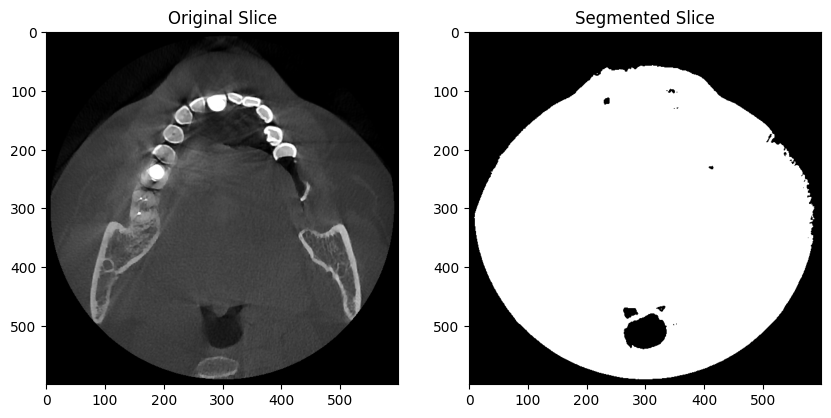

In [15]:
import matplotlib.pyplot as plt

# Visualize a single slice
slice_idx = 50  # Choose any slice index
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Slice")
plt.imshow(image_stack[slice_idx], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Segmented Slice")
plt.imshow(segmented_stack[slice_idx], cmap="gray")
plt.show()



In [20]:
def normalize(volume):
    volume = volume - np.min(volume)
    volume = volume / np.max(volume)
    return volume


In [26]:
import SimpleITK as sitk

def resample_volume(volume, new_spacing=(1.0, 1.0, 1.0)):
    sitk_volume = sitk.GetImageFromArray(volume)
    original_spacing = sitk_volume.GetSpacing()
    original_size = sitk_volume.GetSize()
    new_size = [
        int(np.round(original_size[i] * (original_spacing[i] / new_spacing[i])))
        for i in range(3)
    ]
    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetSize(new_size)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampled_volume = resampler.Execute(sitk_volume)
    return sitk.GetArrayFromImage(resampled_volume)


In [27]:
def extract_slices(volume):
    return [volume[:, :, i] for i in range(volume.shape[2])]


In [29]:
!pip install numpy pydicom opencv-python scikit-image matplotlib SimpleITK nibabel tensorflow keras pytorch torchvision monai

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def unet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    # Add more layers similarly...
    up = UpSampling2D((2, 2))(p1)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(up)
    return Model(inputs, outputs)

model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 57.4 kB/s eta 0:00:0000:0100:07
     ━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━ 216.3/615.3 MB 23.2 kB/s eta 4:46:54
ERROR: Exception:
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/pip/_vendor/urllib3/response.py", line 438, in _error_catcher
    yield
  File "/usr/lib/python3/dist-packages/pip/_vendor/urllib3/response.py", line 519, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "/usr/lib/python3/dist-packages/pip/_vendor/cachecontrol/filewrapper.py", line 90, in read
    data = self.__fp.read(amt)
  File "/usr/lib/python3.10/http/client.py", line 466, in read
    s = self.fp.read(amt)
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
  File "/usr/lib/python3.10/ssl.py", line 1303, in recv_into
    return self.read(nbytes, buffer)
  File "/usr/lib/python3.1

ModuleNotFoundError: No module named 'tensorflow'